# Contact Tracing Model Calibration

In [1]:
import household_contact_tracing as model
import numpy as np
import seaborn as sns
import statsmodels.api as sma
import pandas as pd
from patsy import dmatrices
import scipy.stats as ss

The model calibration class inherits from the base model class, so you are using the exact same code/distributions. The calibration estimates $R_0$ for the model using the methods of Pellis et al. The local and global infections are Monte-Carlo simulated, hence there is uncertainty in the output.

In order to tune the models, we estimate $R_0$ over a variety of inputs, and fit a linear regression to the outputs.

In [2]:
%%time
model_calibration = model.model_calibration(haz_rate_scale = 0.795,
                                            contact_tracing_success_prob = 2/3,
                                            prob_of_successful_contact_trace_today = 1/3,
                                            infection_reporting_prob = 0.2,
                                            reporting_delay_par = 1/4.8,
                                            contact_trace = False,
                                            reduce_contacts_by = 0)
model_calibration.calculate_R0()

CPU times: user 48.2 s, sys: 650 ms, total: 48.8 s
Wall time: 48.7 s


3.2385712190367495

In [3]:
x_vals = np.linspace(0.79, 0.81, 5)
repetitions = 10
hazard_rate_scale = []
R0_estimate = []
for x in x_vals:
    model_calibration = model.model_calibration(haz_rate_scale = x,
                                                contact_tracing_success_prob = 2/3,
                                                prob_of_successful_contact_trace_today = 1/3,
                                                infection_reporting_prob = 0.7,
                                                reporting_delay_par = 1/4.8,
                                                contact_trace = True,
                                                reduce_contacts_by = 0)
    for repeat in range(repetitions):
        print(f"x values : {x}   repeat: {repeat}", end = "\r")
        hazard_rate_scale.append(x)
        R0_estimate.append(model_calibration.calculate_R0())

In [4]:
data = pd.DataFrame({"hazard_rate_scale": hazard_rate_scale,
                     "R0_estimate": R0_estimate})

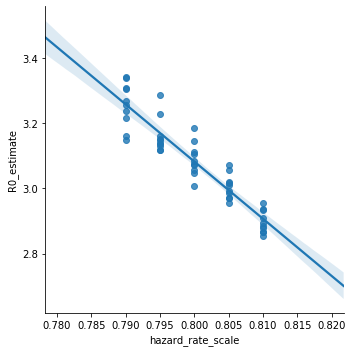

In [5]:
plot = sns.lmplot("hazard_rate_scale", "R0_estimate", data)

In [6]:
y, X = dmatrices('R0_estimate ~ hazard_rate_scale', 
                 data = data)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            R0_estimate   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     313.6
Date:                Fri, 08 May 2020   Prob (F-statistic):           1.10e-22
Time:                        00:13:05   Log-Likelihood:                 80.326
No. Observations:                  50   AIC:                            -156.7
Df Residuals:                      48   BIC:                            -152.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            17.1175      0.79

In [7]:
y = 3
m = res.params[1]
c = res.params[0]
x = (y - c) / m
x

0.8046709837153315

Therefore a hazard rate scale of 0.805 gives $R_0 = 3$